#Import library 2

In [ ]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

#import the library opencv
import cv2
#globbing utility.
import glob

from sklearn.utils import shuffle

%matplotlib inline

In [ ]:
import numpy as np

from PIL import Image

from matplotlib import pyplot
import matplotlib.pylab as plt 
from scipy.signal import convolve2d
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers

#Some imports for getting the CIFAR-10 dataset and for help with visualization*]
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib import cm
from tensorflow import keras
from keras.applications import VGG16

import os
import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping

## Please download the packages that are missing in your colab environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/Post-hurricane.zip"

unzip:  cannot find or open /content/drive/MyDrive/Post-hurricane.zip, /content/drive/MyDrive/Post-hurricane.zip.zip or /content/drive/MyDrive/Post-hurricane.zip.ZIP.


# Loading dataset and split dataset
In this section we load the dataset from the directory. Train dataset are stored in X_train, validation dataset are stored in X_val, and test data set are seperately stored in X_test and X_test_unbal. The if the image is loaded from undamaged, the y label will be 1, otherwise the y label will be 0. After loading the dataset, the data will be shuffled.

In [ ]:
def load_img(path1, path2):
  path = path1
  X_damage = np.array([np.array(cv2.imread(fname)) for fname in glob.glob(path)])
  y_damage = np.ones(X_damage.shape[0])
  path = path2
  X_no_damage = np.array([np.array(cv2.imread(fname)) for fname in glob.glob(path)])
  y_no_damage = np.zeros(X_no_damage.shape[0])
  X = np.append(X_damage,X_no_damage,axis=0)
  y = np.append(y_damage,y_no_damage,axis=0)
  return shuffle(X, y, random_state = 0)

In [ ]:
X_train, y_train = load_img("train_another/damage/*.jpeg", "train_another/no_damage/*.jpeg")
X_val, y_val = load_img("validation_another/damage/*.jpeg", "validation_another/no_damage/*.jpeg")
X_test, y_test = load_img("test/damage/*.jpeg", "test/no_damage/*.jpeg")
X_test_unbal, y_test_unbal = load_img("test_another/damage/*.jpeg", "test_another/no_damage/*.jpeg")

In [ ]:
X_train.shape

(0,)

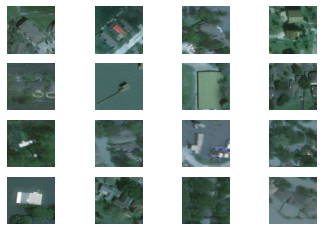

In [ ]:
fig, ax = plt.subplots(4,4)
ax = ax.ravel()
for i in range(16):
  img = X_train[i]
  ax[i].set_axis_off()
  ax[i].imshow(img)

# VGG16 with pre_train

In [ ]:
# fit params
nodes = 100
input_shape = (128,128,3)
activation = "relu"
output_unit = "sigmoid"
loss_fn = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
epochs = 8
batch_size = 50
validation_size = 0.3

In [ ]:
con_base = VGG16(weights="imagenet",include_top = False, input_shape = input_shape)
model = Sequential()
model.add(con_base)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
con_base.trainable=False
model.summary()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
# fit each model
#history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history.history['accuracy'],color='#EFAEA4')
ax[0].plot(history.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history.history['loss'],color='#EFAEA4')
ax[1].plot(history.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

#  Bagging with VGG16 pretrain

In [ ]:
# VGG16 TEST MODEL
weight_decay = 0.0005
nb_epoch=100
batch_size=32
  
#layer1 32*32*3
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
input_shape=input_shape,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#layer2 32*32*64
model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#layer3 16*16*64
model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer4 16*16*128
model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#layer5 8*8*128
model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer6 8*8*256
model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer7 8*8*256
model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#layer8 4*4*256
model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer9 4*4*512
model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer10 4*4*512
model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#layer11 2*2*512
model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer12 2*2*512
model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
#layer13 2*2*512
model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
#layer14 1*1*512
model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#layer15 512
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
#layer16 512
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
# 10
  
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)     

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size, validation_split=0.1, verbose=1, callbacks=[early_stopping])

In [ ]:
y_pred_unbal = model.predict(X_test_unbal)
y_pred = model.predict(X_test)
model.evaluate(X_test_unbal, y_test_unbal)
model.evaluate(X_test, y_test)

In [ ]:
# sampleing & data process
# train the basic classicfier in odd number
basic_classicfier = []
for i in range(9):
  # generate the basic training data of bagging, using shuffle to simulate the process
  # of generating the random dataset which the size of it equals to the original one.
  index = np.linspace(0,9999,10000, dtype = np.int)
  index = shuffle(index)
  new_X_train = []
  new_y_train = []
  for i in index:
    new_X_train.append(X_train[i])
    new_y_train.append(y_train[i])
  new_X_train = np.array(new_X_train)
  new_y_train = np.array(new_y_train)
  # define each model
  # con_base = VGG16(weights="imagenet",include_top = False, input_shape = input_shape)
  # model = Sequential()
  # model.add(con_base)
  # model.add(Flatten())
  # model.add(Dense(512,activation='relu'))
  # model.add(Dense(512,activation='relu'))
  # model.add(Dense(1,activation='sigmoid'))
  # con_base.trainable=False
  # model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
  # fit each model

  # VGG16 TEST MODEL
  weight_decay = 0.0005
  nb_epoch=20
  batch_size=32
    
  #layer1 32*32*3
  model_vgg = Sequential()
  model_vgg.add(Conv2D(64, (3, 3), padding='same',
  input_shape=input_shape,kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.3))
  #layer2 32*32*64
  model_vgg.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(MaxPooling2D(pool_size=(2, 2)))
  #layer3 16*16*64
  model_vgg.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer4 16*16*128
  model_vgg.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(MaxPooling2D(pool_size=(2, 2)))
  #layer5 8*8*128
  model_vgg.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer6 8*8*256
  model_vgg.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer7 8*8*256
  model_vgg.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(MaxPooling2D(pool_size=(2, 2)))
  #layer8 4*4*256
  model_vgg.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer9 4*4*512
  model_vgg.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer10 4*4*512
  model_vgg.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(MaxPooling2D(pool_size=(2, 2)))
  #layer11 2*2*512
  model_vgg.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer12 2*2*512
  model_vgg.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(Dropout(0.4))
  #layer13 2*2*512
  model_vgg.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  model_vgg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg.add(Dropout(0.5))
  #layer14 1*1*512
  model_vgg.add(Flatten())
  model_vgg.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  #layer15 512
  model_vgg.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model_vgg.add(Activation('relu'))
  model_vgg.add(BatchNormalization())
  #layer16 512
  model_vgg.add(Dropout(0.5))
  model_vgg.add(Dense(1))
  model_vgg.add(Activation('sigmoid'))
  # 10
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

  model_vgg.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
  model_vgg.fit(new_X_train, new_y_train, epochs=nb_epoch, batch_size=batch_size, x=0.2, verbose=1, callbacks=[early_stopping])

  print(X_train[0].shape)
  basic_classicfier.append(model_vgg)

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = w.predict_classes(X_test)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = w.predict_classes(X_test_unbal)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test_unbal[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")

In [ ]:
con_base = VGG16(weights="imagenet",include_top=False, input_shape= input_shape)
model4 = Sequential()
model4.add(con_base)
model4.add(Flatten())
model4.add(Dense(512,activation='relu'))
model4.add(Dense(512,activation='relu'))
model4.add(Dense(1,activation='sigmoid'))
con_base.trainable=False

In [ ]:
model4.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"],
)
model4.summary()

In [ ]:
history4 = model4.fit(    
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs, 
    verbose=1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history4.history['accuracy'],color='#EFAEA4')
ax[0].plot(history4.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history4.history['loss'],color='#EFAEA4')
ax[1].plot(history4.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

In [ ]:
y_pred_unbal = model4.predict(X_test_unbal)
y_pred = model4.predict(X_test)
model4.evaluate(X_test_unbal, y_test_unbal)
model4.evaluate(X_test, y_test)

# Basic model

In [ ]:
model1 = tf.keras.models.Sequential(
    [
      Input(shape = input_shape),
      Conv2D(32, 3, strides = (1,1), padding = "same", activation="relu"),
      Conv2D(32, 3, strides = (1,1), activation="relu"),
      MaxPooling2D(pool_size = (2,2), strides = 2),
      Conv2D(64, 3, strides = (1,1), padding = "same", activation="relu"),
      Conv2D(64, 3, strides = (1,1), activation="relu"),
      MaxPooling2D(pool_size = (2,2), strides = 2),
      Flatten(),
      Dense(128, activation = "relu"),
      Dropout(0.2),
      Dense(32, activation = "relu"),
      Dense(1, activation = "sigmoid")
    ]
)

model1.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"],
)

model1.summary()

In [ ]:
history = model1.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs, 
    verbose=1
)

# Alexnet 

In [ ]:
# fit params
nodes = 100
input_shape = (128,128,3)
activation = "relu"
output_unit = "sigmoid"
loss_fn = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
epochs = 8
batch_size = 50
validation_size = 0.3

In [ ]:
# fit params
nodes = 100
input_shape = (128,128,3)
activation = "relu"
output_unit = "sigmoid"
loss_fn = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
epochs = 8
batch_size = 50
validation_size = 0.3

model_alexnet = Sequential()  
model_alexnet.add(Conv2D(96,(11,11),strides=(4,4),input_shape=input_shape,padding='valid',activation='relu',kernel_initializer='uniform'))  
model_alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model_alexnet.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model_alexnet.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model_alexnet.add(Flatten())  
model_alexnet.add(Dense(4096,activation='relu'))  
model_alexnet.add(Dropout(0.5))  
model_alexnet.add(Dense(4096,activation='relu'))  
model_alexnet.add(Dropout(0.5))  
model_alexnet.add(Dense(1,activation='sigmoid'))  

model_alexnet.compile(loss=keras.losses.binary_crossentropy,optimizer= 'adam',metrics=['accuracy'])  
model_alexnet.summary()  

In [ ]:
model_alexnet_1 = Sequential()  
model_alexnet_1.add(Conv2D(96,(5,5),strides=(4,4),input_shape=input_shape,padding='valid',activation='relu',kernel_initializer='uniform'))  
model_alexnet_1.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model_alexnet_1.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet_1.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model_alexnet_1.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet_1.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet_1.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model_alexnet_1.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model_alexnet_1.add(Flatten())  
model_alexnet_1.add(Dense(1024,activation='relu'))  
model_alexnet_1.add(Dropout(0.5))  
model_alexnet_1.add(Dense(1024,activation='relu'))  
model_alexnet_1.add(Dropout(0.5))  
model_alexnet_1.add(Dense(1,activation='sigmoid'))  
sgd = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model_alexnet_1.compile(loss=keras.losses.binary_crossentropy,optimizer= 'adam',metrics=['accuracy'])  
model_alexnet_1.summary()  

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model_alexnet_1.fit(X_train, y_train,epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model_alexnet.fit(X_train, y_train,epochs=20, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs, 
    verbose=1
)

In [ ]:
y_pred_unbal = model.predict(X_test_unbal)
y_pred = model.predict(X_test)
model.evaluate(X_test_unbal, y_test_unbal)
model.evaluate(X_test, y_test)

# Model A

In [ ]:
model2=Sequential()
model2.add(Conv2D(64,((2,2)),padding='same',input_shape=input_shape,activation='relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64,((2,2)),padding='same',activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2,2),strides=2))
 
model2.add(Conv2D(128,((2,2)),padding='same',activation='relu'))
model2.add(Conv2D(128,((2,2)),padding='same',activation='relu'))
model2.add(MaxPooling2D((2,2),strides=2))
 
model2.add(Conv2D(64,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(64,(1,1),padding='same',activation='relu'))
model2.add(MaxPooling2D((2,2),strides=2))
 
model2.add(Conv2D(128,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(128,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(128,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(128,(1,1),padding='same',activation='relu'))
model2.add(MaxPooling2D((2,2),strides=2))
 
model2.add(Conv2D(32,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(32,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(32,(1,1),padding='same',activation='relu'))
model2.add(Conv2D(32,(1,1),padding='same',activation='relu'))
model2.add(MaxPooling2D((2,2),strides=2))
 
model2.add(Flatten())
# model2.add(Dense(1024,activation='relu'))
model2.add(Dense(512,activation='relu'))
model2.add(Dense(512,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer= optimizer,
              loss= keras.losses.binary_crossentropy,
              metrics= ['accuracy'])
model2.summary()

In [ ]:
# VGG16
history = model2.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs, 
    verbose=1
)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history.history['accuracy'],color='#EFAEA4')
ax[0].plot(history.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history.history['loss'],color='#EFAEA4')
ax[1].plot(history.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

In [ ]:
y_pred_unbal = model2.predict(X_test_unbal)
y_pred = model2.predict(X_test)
model2.evaluate(X_test_unbal, y_test_unbal)
model2.evaluate(X_test, y_test)

In [ ]:
num = 15
model.evaluate(X_test_unbal[num].reshape(-1,128,128,3), y_test_unbal[num].reshape(-1,1))
y_test_unbal[num].reshape(-1,1),model.predict(X_test_unbal[num].reshape(-1,128,128,3))
# fig, ax = plt.subplots(1,1)
# ax.imshow(X_test_unbal[num])

# Resnet with pre-train

In [ ]:
# fit params
nodes = 100
input_shape = (128,128,3)
activation = "relu"
output_unit = "sigmoid"
loss_fn = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
epochs = 8
batch_size = 50
validation_size = 0.3

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

con_base5 = ResNet50(weights='imagenet', include_top = False, input_shape = input_shape)
model5 = Sequential()
model5.add(con_base5)
model5.add(Flatten())
model5.add(Dense(512,activation='relu'))
model5.add(Dropout(0.4))
model5.add(Dense(512,activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(1,activation='sigmoid'))
con_base5.trainable=False
model5.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
# fit each model
history = model5.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=epochs, verbose=1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history.history['accuracy'],color='#EFAEA4')
ax[0].plot(history.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history.history['loss'],color='#EFAEA4')
ax[1].plot(history.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

# Xception with pre_train

In [ ]:
from tensorflow.keras.applications.xception import Xception

input_shape = (128,128,3)
loss_fn = tf.keras.losses.binary_crossentropy
optimizer = tf.keras.optimizers.Adam()
epochs = 8
batch_size = 50

In [ ]:
# sampleing & data process
# train the basic classicfier in odd number
basic_classicfier = []
for i in range(9):
  # generate the basic training data of bagging, using shuffle to simulate the process
  # of generating the random dataset which the size of it equals to the original one.
  index = np.linspace(0,9999,10000, dtype = np.int)
  index = shuffle(index)
  new_X_train = []
  new_y_train = []
  for i in index:
    new_X_train.append(X_train[i])
    new_y_train.append(y_train[i])
  new_X_train = np.array(new_X_train)
  new_y_train = np.array(new_y_train)

  con_base_Xcep = Xception(weights='imagenet', include_top = False, input_shape = input_shape)
  model_Xcep = Sequential()
  model_Xcep.add(con_base_Xcep)
  model_Xcep.add(Flatten())
  model_Xcep.add(Dense(512,activation='relu'))
  model_Xcep.add(Dense(512,activation='relu'))
  model_Xcep.add(Dense(1,activation='sigmoid'))
  con_base_Xcep.trainable=False
  model_Xcep.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])
  # fit each model
  history_Xcep = model_Xcep.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=epochs, verbose=1)

  basic_classicfier.append(model_Xcep)

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = w.predict_classes(X_test_unbal)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test_unbal[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history.history['accuracy'],color='#EFAEA4')
ax[0].plot(history.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history.history['loss'],color='#EFAEA4')
ax[1].plot(history.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

# Xception Model


In [ ]:
import os  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, Dense, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, add
from keras.models import Model
from keras.layers import SeparableConv2D

from keras import optimizers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint

batch_size         = 32         # 64 or 32 or other
epochs             = 8

# 36 convolutional layers are structured into 14 modules
def entryflow(x,params,top=False):
    # modules 2-4,13
    # params is (3,)
    # top = true means module 2, don't use relu
    residual = Conv2D(params[0], (1, 1), strides=(2, 2),padding='same')(x)
    residual = BatchNormalization()(residual)
    if top:
        x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[2], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2),padding='same')(x)
    x = add([x, residual])
    return x

def middleflow(x,params):
    # modules 5-12, params is int
    residual = x
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, residual])
    return x

def exitflow(x,params):
    # modules 14 , params is (2,)
    x = SeparableConv2D(params[0], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (3, 3),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   
    return x

def xception(img_input,shallow=False, classes=1):
    # modules 1
    x = Conv2D(32,(3, 3),strides=(2, 2),padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3),strides=(1,1),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # module 2
    x = entryflow(x,(128,128,128),top=True)
    # module 3-4
    x = entryflow(x,(256,256,256))
    x = entryflow(x,(728,728,728))
    # module 5-12
    for _ in range(8):
        x = middleflow(x,728)
    # module 13
    x = entryflow(x,(1024,728,1024))
    # module 14
    x = exitflow(x,(1536,2048))
    # output
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)
    return x

In [ ]:
img_input=Input(shape=(128,128,3))
output = xception(img_input)
model_Xcep=Model(img_input,output)
model_Xcep.summary()
model_Xcep.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [ ]:
# sampleing & data process
# train the basic classicfier in odd number
basic_classicfier = []
for i in range(9):
  # generate the basic training data of bagging, using shuffle to simulate the process
  # of generating the random dataset which the size of it equals to the original one.
  index = np.linspace(0,9999,10000, dtype = np.int)
  index = shuffle(index)
  new_X_train = []
  new_y_train = []
  for i in index:
    new_X_train.append(X_train[i])
    new_y_train.append(y_train[i])
  new_X_train = np.array(new_X_train)
  new_y_train = np.array(new_y_train)
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)

  # fit each model
  history_Xcep = model_Xcep.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=epochs, verbose=1, callbacks=early_stopping)

  basic_classicfier.append(model_Xcep)

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = w.predict_classes(X_test_unbal)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test_unbal[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history.history['accuracy'],color='#EFAEA4')
ax[0].plot(history.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history.history['loss'],color='#EFAEA4')
ax[1].plot(history.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

# Simple Xception Model


In [ ]:
import os  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, Dense, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, add
from keras.models import Model
from keras.layers import SeparableConv2D

from keras import optimizers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint

batch_size         = 32         # 64 or 32 or other
epochs             = 8

# 36 convolutional layers are structured into 14 modules
def entryflow(x,params,top=False):
    # modules 2-4,13
    # params is (3,)
    # top = true means module 2, don't use relu
    residual = Conv2D(params[0], (1, 1), strides=(2, 2),padding='same')(x)
    residual = BatchNormalization()(residual)
    if top:
        x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[2], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2),padding='same')(x)
    x = add([x, residual])
    return x

def middleflow(x,params):
    # modules 5-12, params is int
    residual = x
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, residual])
    return x

def exitflow(x,params):
    # modules 14 , params is (2,)
    x = SeparableConv2D(params[0], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   
    return x

def xception(img_input,shallow=False, classes=1):
    # modules 1
    x = Conv2D(32,(2, 2),strides=(2, 2),padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (2, 2),strides=(1,1),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # module 2
    x = entryflow(x,(32,32,32),top=True)
    # module 3-4
    x = entryflow(x,(32,32,32))
    x = entryflow(x,(32,32,32))
    # module 5-12
    for _ in range(8):
        x = middleflow(x,32)
    # module 13
    x = entryflow(x,(128,128,128))
    # module 14
    x = exitflow(x,(128,128))
    # output
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='sigmoid')(x)
    return x

In [ ]:
img_input=Input(shape=(128,128,3))
output = xception(img_input)
model_Xcep=Model(img_input,output)
model_Xcep.summary()

model_Xcep.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
# sampleing & data process
# train the basic classicfier in odd number
basic_classicfier = []
for i in range(9):
  # generate the basic training data of bagging, using shuffle to simulate the process
  # of generating the random dataset which the size of it equals to the original one.
  index = np.linspace(0,9999,10000, dtype = np.int)
  index = shuffle(index)
  new_X_train = []
  new_y_train = []
  for i in index:
    new_X_train.append(X_train[i])
    new_y_train.append(y_train[i])
  new_X_train = np.array(new_X_train)
  new_y_train = np.array(new_y_train)
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=2)

  # fit each model
  history_Xcep = model_Xcep.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), epochs=epochs, verbose=1, callbacks=early_stopping)

  basic_classicfier.append(model_Xcep)

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = model_Xcep.predict(X_test_unbal)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test_unbal[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
ax[0].plot(history_Xcep.history['accuracy'],color='#EFAEA4')
ax[0].plot(history_Xcep.history['val_accuracy'], color='#B2D7D0')
ax[1].plot(history_Xcep.history['loss'],color='#EFAEA4')
ax[1].plot(history_Xcep.history['val_loss'], color='#B2D7D0')
ax[0].set_title('Model accuracy')
ax[1].set_title('Model loss')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='best')
ax[1].legend(['Train', 'Test'], loc='best')
plt.show()

# Occlusion

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127
    # patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, 0] = image[:,:,0].mean()
    # patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, 1] = image[:,:,1].mean()
    # patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, 2] = image[:,:,2].mean()
    return patched_image

In [ ]:
def load_dataset():
	
	#load dataframe
  path = "train_another/damage/*.jpeg"
  X_damage_df = np.array([np.array(fname) for fname in glob.glob(path)])
  y_damage_df = np.ones(X_damage_df.shape[0]).astype(int).astype(str)
  path = "train_another/no_damage/*.jpeg"
  X_no_damage_df = np.array([np.array(fname) for fname in glob.glob(path)])
  y_no_damage_df = np.zeros(X_no_damage_df.shape[0]).astype(int).astype(str)
  X_df = np.append(X_damage_df,X_no_damage_df,axis=0)
  y_df = np.append(y_damage_df,y_no_damage_df,axis=0)
  X_df, y_df = shuffle(X_df, y_df, random_state = 0)
  df = pd.DataFrame({"image":X_df,"label":y_df})
  
  generator = ImageDataGenerator(rescale=1./255)
  
  data_gen = generator.flow_from_dataframe(
    df, directory=None, x_col='image', y_col='label',
    target_size=(128,128), color_mode='rgb', seed=30,
    class_mode='categorical', batch_size=50, shuffle=False,
    save_format='jpeg', subset='training')
  
  return data_gen, df

In [ ]:
def occlusion(model, X, y, img_num=10, patch_size=4):

  # Load image from the test data
  data_gen, df = load_dataset()
  label_dict = { 0: 'no_damage', 1: 'damage'}
  

  num = img_num

  if num>49:
    num=1

  # Get image 
  img = X[num]

  # Get label
  y_test = y[num]

  # Get the patch size for occlusion
  PATCH_SIZE = patch_size

  # Get the loss of the model with the original image
  loss = model.evaluate(img.reshape(-1,128,128,3), y_test.reshape(-1,1), verbose=0)

  # Define a numpy array to store the loss differences
  loss_map = np.zeros((img.shape[0], img.shape[1]))
  
  #test
  pat = apply_grey_patch(img, 30, 30, 30)
  #  pat = apply_grey_patch(pat, 90, 0, 60)
  fig, ax = plt.subplots(1,1)
  ax.imshow(pat)
  #print(pat)

  step = 5
  # Iterate the patch over the entire image
  for top_left_x in range(0, img.shape[0], step):

    for top_left_y in range(0, img.shape[1], step):
        
      # Initialise a new patched image
      patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)

      # Get the loss of the model for each patched version
      result = model.evaluate(patched_image.reshape(-1,128,128,3), y_test.reshape(-1,1), verbose=0)

      # Get the loss_map of the plot by computing the difference in loss from the original version to the patched value
      loss_map[top_left_y:top_left_y + PATCH_SIZE, top_left_x:top_left_x + PATCH_SIZE] += loss[0] - result[0]
  # print(loss_map.shape)

  # Get the predicted label 
  y_prob = model.predict(img.reshape(-1,128,128,3))
  y_pred = label_dict[1 if y_prob >= 0.5 else 0]
  


  # Get true label	
  y_true = label_dict[y_test]

  
  # print(model.evaluate(pat.reshape(-1,128,128,3), y_test.reshape(-1,1), verbose=0))
  # print(model.predict(pat.reshape(-1,128,128,3)))
  # print(loss_map.shape)

  # Plot the original image along with the difference in loss as a heatmap
  fig, ax = plt.subplots(1,2, figsize=(15,15))
  plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
  ax[0].imshow(img)
  ax[1].imshow(img, cmap='gray')
  im = ax[1].imshow(-loss_map, cmap='Reds', alpha=0.5)
  fig.colorbar(im,fraction=0.05)
  ax[0].set_title("True Label: "+y_true.upper(), fontsize=15)
  ax[1].set_title("Predicted label with patch size "+str(PATCH_SIZE)+": "+y_pred.upper(), fontsize=15)

In [ ]:
img_num = 23
patch_size = 30

occlusion(model5, X_train, y_train, img_num , patch_size)

# 集成模型

In [ ]:
basic_classicfier = []

In [ ]:
  index = np.linspace(0,9999,10000, dtype = np.int)
  index = shuffle(index)
  new_X_train = []
  new_y_train = []
  for j in index:
    new_X_train.append(X_train[j])
    new_y_train.append(y_train[j])
  new_X_train = np.array(new_X_train)
  new_y_train = np.array(new_y_train)
  # VGG16 TEST MODEL
  weight_decay = 0.0005
  nb_epoch=20
  batch_size=32

IndexError: ignored

In [ ]:
# Function of AlexNet
def Alexnet():
  model_alexnet_1 = Sequential()  
  model_alexnet_1.add(Conv2D(96,(5,5),strides=(4,4),input_shape=input_shape,padding='valid',activation='relu',kernel_initializer='uniform'))  
  model_alexnet_1.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
  model_alexnet_1.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
  model_alexnet_1.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
  model_alexnet_1.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
  model_alexnet_1.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
  model_alexnet_1.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
  model_alexnet_1.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
  model_alexnet_1.add(Flatten())  
  model_alexnet_1.add(Dense(1024,activation='relu'))  
  model_alexnet_1.add(Dropout(0.5))  
  model_alexnet_1.add(Dense(1024,activation='relu'))  
  model_alexnet_1.add(Dropout(0.5))  
  model_alexnet_1.add(Dense(1,activation='sigmoid'))  
  sgd = keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
  model_alexnet_1.compile(loss=keras.losses.binary_crossentropy,optimizer= 'adam',metrics=['accuracy'])  
  model_alexnet_1.summary()  

  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
  model_alexnet_1.fit(new_X_train, new_y_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

  basic_classicfier.append(model_alexnet_1)
Alexnet()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 31, 31, 96)        7296      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 15, 15, 256)       614656    
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 7, 384)         885120    
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 7, 7, 256)        

In [ ]:
def vgg16():
  # VGG16 TEST MODEL
  weight_decay = 0.0005
  nb_epoch=100
  batch_size=32
    
  #layer1 32*32*3
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding='same',
  input_shape=input_shape,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  #layer2 32*32*64
  model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #layer3 16*16*64
  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer4 16*16*128
  model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #layer5 8*8*128
  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer6 8*8*256
  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer7 8*8*256
  model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #layer8 4*4*256
  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer9 4*4*512
  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer10 4*4*512
  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #layer11 2*2*512
  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer12 2*2*512
  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  #layer13 2*2*512
  model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  #layer14 1*1*512
  model.add(Flatten())
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  #layer15 512
  model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  #layer16 512
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  # 10
    
  sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
  model.fit(new_X_train, new_y_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])
  basic_classicfier.append(model)
vgg16()

Epoch 1/100
250/250 [==============================] - 57s 197ms/step - loss: 3.3971 - accuracy: 0.7720 - val_loss: 2.6951 - val_accuracy: 1.0000
Epoch 2/100
250/250 [==============================] - 48s 193ms/step - loss: 2.5904 - accuracy: 0.9979 - val_loss: 2.1799 - val_accuracy: 1.0000
Epoch 3/100
250/250 [==============================] - 48s 194ms/step - loss: 2.0582 - accuracy: 0.9996 - val_loss: 1.6935 - val_accuracy: 1.0000
Epoch 4/100
250/250 [==============================] - 48s 194ms/step - loss: 1.5866 - accuracy: 0.9996 - val_loss: 1.2795 - val_accuracy: 1.0000
Epoch 5/100
250/250 [==============================] - 48s 194ms/step - loss: 1.1929 - accuracy: 0.9998 - val_loss: 0.9629 - val_accuracy: 1.0000
Epoch 6/100
250/250 [==============================] - 49s 194ms/step - loss: 0.8842 - accuracy: 1.0000 - val_loss: 0.6978 - val_accuracy: 1.0000
Epoch 7/100
250/250 [==============================] - 48s 194ms/step - loss: 0.6485 - accuracy: 1.0000 - val_loss: 0.5107 -

KeyboardInterrupt: ignored

In [ ]:
basic_classicfier.append(model)

NameError: ignored

In [ ]:
# Xception function

import os  
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import keras
from keras.datasets import cifar10
from keras import backend as K
from keras.layers import Input, Conv2D, Dense, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, add
from keras.models import Model
from keras.layers import SeparableConv2D

from keras import optimizers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import he_normal
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint

batch_size         = 32         # 64 or 32 or other
epochs             = 8

# 36 convolutional layers are structured into 14 modules
def entryflow(x,params,top=False):
    # modules 2-4,13
    # params is (3,)
    # top = true means module 2, don't use relu
    residual = Conv2D(params[0], (1, 1), strides=(2, 2),padding='same')(x)
    residual = BatchNormalization()(residual)
    if top:
        x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[2], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2),padding='same')(x)
    x = add([x, residual])
    return x

def middleflow(x,params):
    # modules 5-12, params is int
    residual = x
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params, (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x, residual])
    return x

def exitflow(x,params):
    # modules 14 , params is (2,)
    x = SeparableConv2D(params[0], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(params[1], (2, 2),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)   
    return x

def xception(img_input,shallow=False, classes=1):
    # modules 1
    x = Conv2D(32,(2, 2),strides=(2, 2),padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (2, 2),strides=(1,1),padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # module 2
    x = entryflow(x,(32,32,32),top=True)
    # module 3-4
    x = entryflow(x,(32,32,32))
    x = entryflow(x,(32,32,32))
    # module 5-12
    for _ in range(8):
        x = middleflow(x,32)
    # module 13
    x = entryflow(x,(128,128,128))
    # module 14
    x = exitflow(x,(128,128))
    # output
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='sigmoid')(x)
    return x
img_input=Input(shape=(128,128,3))
output = xception(img_input)
model_Xcep=Model(img_input,output)
model_Xcep.summary()

model_Xcep.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
model_Xcep.fit(new_X_train, new_y_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   416         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

NameError: ignored

In [ ]:
# sampleing & data process
# train the basic classicfier in odd number
for i in range(3):
  # generate the basic training data of bagging, using shuffle to simulate the process
  # of generating the random dataset which the size of it equals to the original one.
  index = np.linspace(0,9999,10000, dtype = np.int)
  index = shuffle(index)
  new_X_train = []
  new_y_train = []
  for j in index:
    new_X_train.append(X_train[i])
    new_y_train.append(y_train[i])
  new_X_train = np.array(new_X_train)
  new_y_train = np.array(new_y_train)
  # VGG16 TEST MODEL
  weight_decay = 0.0005
  nb_epoch=20
  batch_size=32
  # The Defination of Model
  if i== 0:
    Alexnet()
  if i==1:
    vgg16()
  if i==2:
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2)
    model_Xcep.fit(new_X_train, new_y_train, epochs=nb_epoch, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 31, 31, 96)        7296      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 15, 15, 256)       614656    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 384)         885120    
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 256)        

NameError: ignored

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = w.predict_classes(X_test)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")

In [ ]:
# the process of bagging
# fit each model using the original data
res_pre = []
for w in basic_classicfier:
  pre_res = w.predict_classes(X_test_unbal)
  res_pre.append(pre_res)
# the process of voting
right_count = 0
new_res = []
# presicion and recall
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(2000):
  res_tmp = []
  for item in res_pre:
    res_tmp.append(item[i])
  res_val_0 = res_tmp.count(0)
  res_val_1 = res_tmp.count(1)
  if res_val_0 > res_val_1:
    res_val = 0
  else:
    res_val = 1
  new_res.append(res_val)
  if res_val == y_test_unbal[i]:
    right_count += 1
    if res_val == 1:
      tp += 1
    if res_val == 0:
      tn += 1
  else:
    if res_val == 1:
      fp += 1
    if res_val == 0:
      fn += 1
recall = tp/(tp+fn)
precise = tp/(tp+fp)
bagging_accuracy = right_count/2000*100
print("accuracy: " + str(bagging_accuracy) + "%")
print("recall: " + str(recall) + "%")
print("precise: " + str(precise) + "%")